In [65]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Data Preparation

In [89]:
def sigmoid(x):
  return 1/(1+np.exp(-x))
def grad_sigmoid(x):
  return sigmoid(x)*(1-sigmoid(x))
def relu(x):
  return np.maximum(0, x)

def grad_relu(x):
    return np.where(x > 0, 1, 0)

In [15]:
import numpy as np

std_data = np.array([[0, 0], [1, 0], [0, 1], [1, 1]])

operations = {'XOR': [0, 1, 1, 0],
              'AND': [0, 0, 0, 1],
              'OR':  [0, 1, 1, 1]
              }

def generate_data(operation, n_samples):
    inp_data = []
    inp_targets = []

    for i in range(n_samples // 4):
        noise = np.random.normal(0, 0.1, std_data.shape)
        data = std_data + noise

        if len(inp_data) == 0:
            inp_data = data
        else:
            inp_data = np.vstack((inp_data, data))
        targets = np.array(operations[operation]).reshape(-1, 1)
        if len(inp_targets) == 0:
            inp_targets = targets
        else:
            inp_targets = np.vstack((inp_targets, targets))

    return inp_data, inp_targets



def train_test_split(dataset,targets,split_idx=0.8):
  dataset = np.array(dataset)
  targets = np.array(targets)

  indices = np.arange(dataset.shape[0])
  np.random.shuffle(indices)

  dataset = dataset[indices]
  targets = targets[indices]

  split_idx = int(0.8 * len(dataset))

  training_data = dataset[:split_idx]
  testing_data = dataset[split_idx:]

  training_targets = targets[:split_idx]
  testing_targets = targets[split_idx:]

  return training_data,testing_data,training_targets,testing_targets


# Neural Network

In [136]:
class Ann():
  def __init__(self,input_nodes=2,hidden_nodes=2,output_nodes=1,lr=0.01):
    self.input_nodes = input_nodes
    self.hidden_nodes = hidden_nodes
    self.output_nodes = output_nodes
    self.lr = lr

    self.weights_1 = np.random.randn(self.input_nodes, self.hidden_nodes)
    self.weights_2 = np.random.randn(self.hidden_nodes, self.output_nodes)
    self.bias_1 = np.random.randn(self.hidden_nodes)
    self.bias_2 = np.random.randn(self.output_nodes)

  def FeedForward(self,inputs):
    self.z_1 = np.dot(inputs,self.weights_1)+self.bias_1
    self.a_1 = sigmoid(self.z_1)

    self.z_out= np.dot(self.a_1,self.weights_2)+self.bias_2
    self.a_out = sigmoid(self.z_out)

    return self.a_out

  def backpropagate(self,inputs,targets):

    error_output = (self.a_out - targets) * grad_sigmoid(self.z_out)
    error_hidden = error_output.dot(self.weights_2.T) * grad_sigmoid(self.z_1)

    # Gradient updates
    grad_weights_2 = self.a_1.T.dot(error_output)
    grad_weights_1 = inputs.T.dot(error_hidden)

    # Update weights and biases
    self.weights_2 -= self.lr * grad_weights_2
    self.weights_1 -= self.lr * grad_weights_1
    self.bias_2 -= self.lr * np.sum(error_output, axis=0)
    self.bias_1 -= self.lr * np.sum(error_hidden, axis=0)

  def loss(self,predicted,actual):
    return 0.5*np.sum((predicted-actual)**2)

  def accuracy(self,predicted,actual):
    predicted_labels = (predicted >= 0.5).astype(int)
    return np.mean(predicted_labels == actual) * 100

  def deterministic_train(self,inputs,targets,test_inputs,test_targets,epochs=1000):

    train_losses,test_losses = [],[]
    train_accuracies,test_accuracies = [],[]
    for epoch in range(epochs):
      self.FeedForward(inputs)
      self.backpropagate(inputs,targets)
      train_pred = self.FeedForward(inputs)
      test_pred = self.FeedForward(test_inputs)

      # train_pred = (train_pred >= 0.5).astype(int)
      # test_pred = (test_pred >= 0.5).astype(int)

      train_loss = self.loss(train_pred,targets)
      test_loss = self.loss(test_pred,test_targets)

      train_losses.append(train_loss)
      test_losses.append(test_loss)

      train_acc = self.accuracy(train_pred,targets)
      test_acc = self.accuracy(test_pred,test_targets)

      train_accuracies.append(train_acc)
      test_accuracies.append(test_acc)

    return train_losses, test_losses, train_accuracies, test_accuracies
  def SGD_train(self,inputs,targets,test_inputs,test_targets,batch_size=16,epochs=1000):

    n_samples = inputs.shape[0]
    train_losses,test_losses = [],[]
    train_accuracies,test_accuracies = [],[]
    for epoch in range(epochs):
      indices = np.arange(n_samples)
      np.random.shuffle(indices)
      inputs = inputs[indices]
      targets = targets[indices]
      for i in range(0, n_samples, batch_size):
        x_batch = inputs[i:i + batch_size]
        y_batch = targets[i:i + batch_size]

        self.FeedForward(x_batch)
        self.backpropagate(x_batch, y_batch)
      # if epoch%100==0:
      #   print(f'Weights after update{epoch}:', self.weights_1, self.weights_2)
      train_pred = self.FeedForward(inputs)
      test_pred = self.FeedForward(test_inputs)
      # train_pred = (train_pred >= 0.5).astype(int)
      # test_pred = (test_pred >= 0.5).astype(int)

      train_loss = self.loss(train_pred,targets)
      test_loss = self.loss(test_pred,test_targets)

      train_losses.append(train_loss)
      test_losses.append(test_loss)

      train_acc = self.accuracy(train_pred,targets)
      test_acc = self.accuracy(test_pred,test_targets)

      train_accuracies.append(train_acc)
      test_accuracies.append(test_acc)

    return train_losses, test_losses, train_accuracies, test_accuracies



#Plotting

In [131]:
def plot_graphs(train_losses, test_losses, train_accuracies, test_accuracies,Model):


  fig, axs = plt.subplots(1, 2, figsize=(12, 5))

  # Subplot 1: Loss
  axs[0].plot(train_losses, label="Train Loss ")
  axs[0].plot(test_losses, label="Test Loss ")
  axs[0].set_title(f"{Model}: Training & Testing Loss")
  axs[0].set_xlabel("Epochs")
  axs[0].set_ylabel("Loss")
  axs[0].legend()

  # Subplot 2: Accuracy
  axs[1].plot(train_accuracies, label="Train Accuracy (GD)")
  axs[1].plot(test_accuracies, label="Test Accuracy (GD)")
  axs[1].set_title(f"{Model}: Training & Testing Accuracy")
  axs[1].set_xlabel("Epochs")
  axs[1].set_ylabel("Accuracy (%)")
  axs[1].legend()

  plt.tight_layout()

  plt.show()

#Testing

In [137]:
def Deterministic_Model(X_train, y_train, X_test, y_test):
    ann = Ann()

    train_losses_gd, test_losses_gd, train_accuracies_gd, test_accuracies_gd = ann.deterministic_train(X_train, y_train, X_test, y_test, epochs=1000)

    results = {
        "Deterministic_GD": {
            "Final_Training_Accuracy": train_accuracies_gd[-1],
            "Final_Testing_Accuracy": test_accuracies_gd[-1],
            "Final_Training_Loss": train_losses_gd[-1],
            "Final_Testing_Loss": test_losses_gd[-1]
        }
    }
    results_df = pd.DataFrame(results)
    print(results_df)

    plot_graphs(train_losses_gd, test_losses_gd, train_accuracies_gd, test_accuracies_gd,'Deterministic')




In [138]:
def SGD_Model(X_train, y_train, X_test, y_test,size):
    ann = Ann()

    train_losses_sgd, test_losses_sgd, train_accuracies_sgd, test_accuracies_sgd = ann.SGD_train(X_train, y_train, X_test, y_test, epochs=1000, batch_size=size)

    results = {
        "SGD": {
            "Final_Training_Accuracy": train_accuracies_sgd[-1],
            "Final_Testing_Accuracy": test_accuracies_sgd[-1],
            "Final_Training_Loss": train_losses_sgd[-1],
            "Final_Testing_Loss": test_losses_sgd[-1]
        }
    }
    results_df = pd.DataFrame(results)
    print(results_df)

    plot_graphs(train_losses_sgd, test_losses_sgd, train_accuracies_sgd, test_accuracies_sgd,'SGD')




## mixed dataset

                         Deterministic_GD
Final_Testing_Accuracy          66.666667
Final_Testing_Loss               2.398063
Final_Training_Accuracy         77.083333
Final_Training_Loss              7.909885


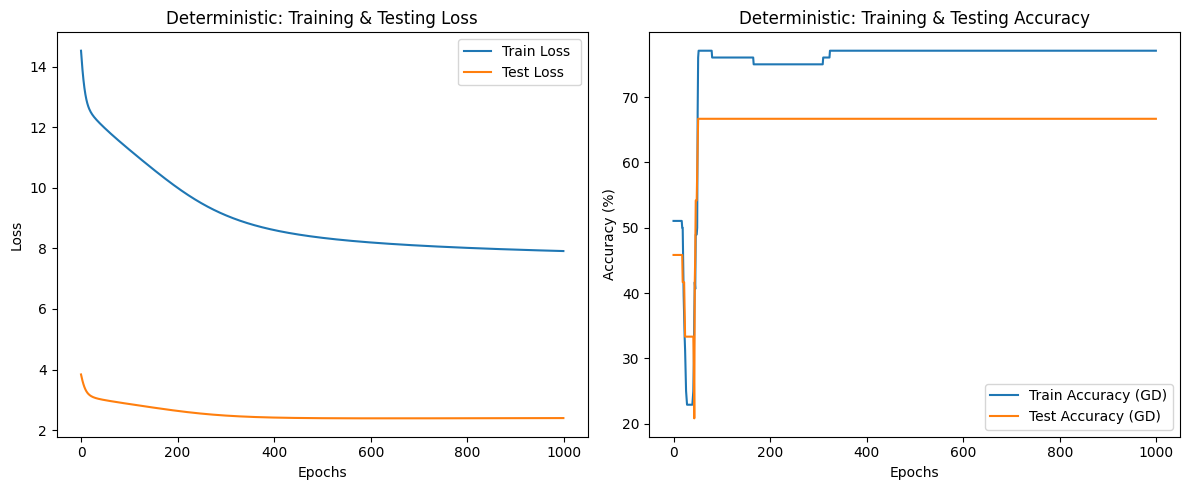

                               SGD
Final_Testing_Accuracy   66.666667
Final_Testing_Loss        2.392583
Final_Training_Accuracy  77.083333
Final_Training_Loss       7.818075


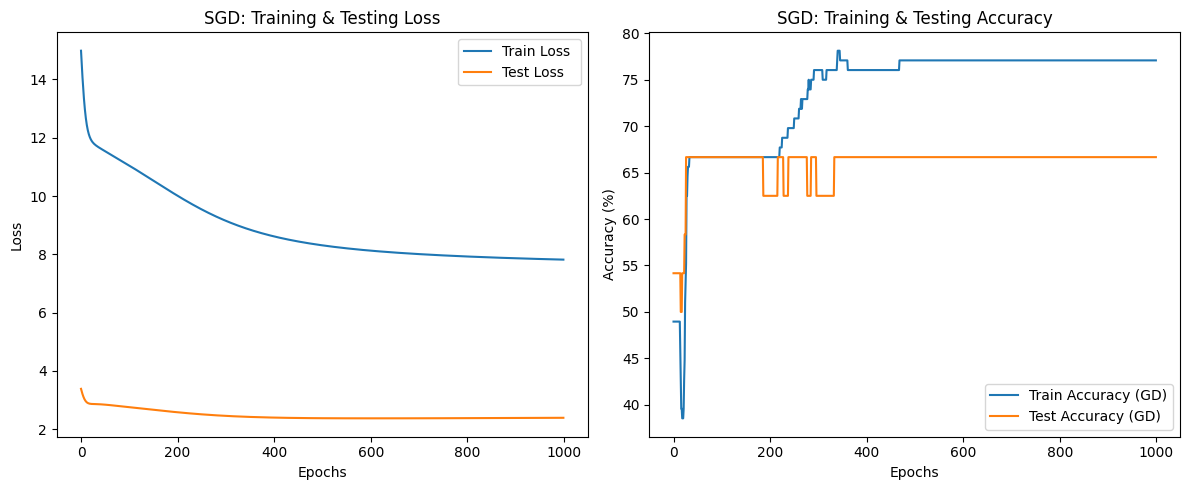

In [139]:
dataset = []
targets = []
for key in operations.keys():
  data,labels = generate_data(key,40)
  if len(dataset) == 0:
        dataset = data
        targets = labels
  else:
      dataset = np.vstack((dataset, data))
      targets = np.vstack((targets, labels))

X_train,X_test,y_train,y_test = train_test_split(dataset,targets)
Deterministic_Model(X_train, y_train, X_test, y_test)
SGD_Model(X_train, y_train, X_test, y_test,size=16)

## Operation-wise  Dataset


--- Sample Size: 200 ---

--- XOR Dataset ---
                         Deterministic_GD
Final_Testing_Accuracy         100.000000
Final_Testing_Loss               0.753869
Final_Training_Accuracy         98.958333
Final_Training_Loss              2.678780


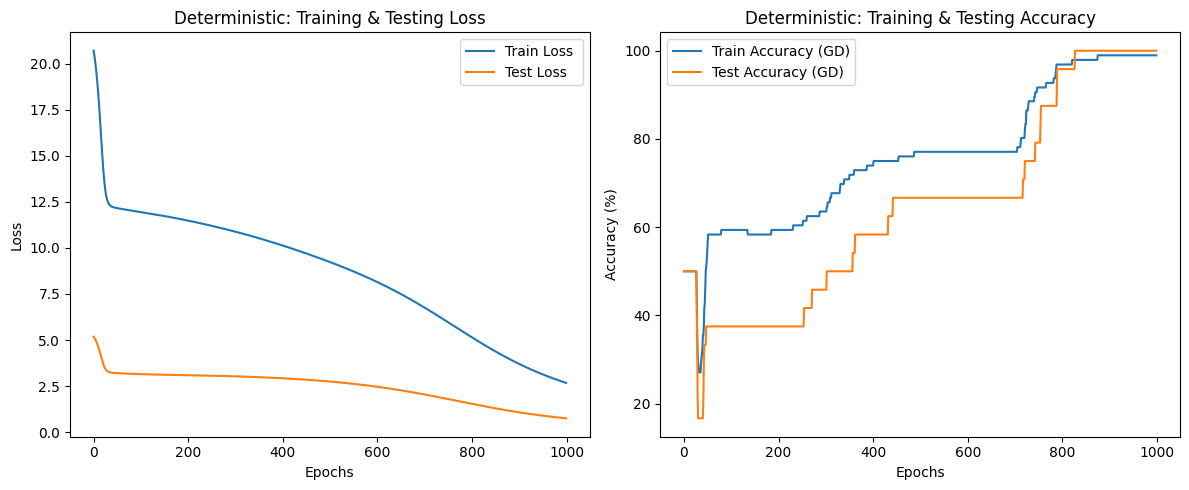


--- AND Dataset ---
                         Deterministic_GD
Final_Testing_Accuracy         100.000000
Final_Testing_Loss               0.109388
Final_Training_Accuracy        100.000000
Final_Training_Loss              0.470815


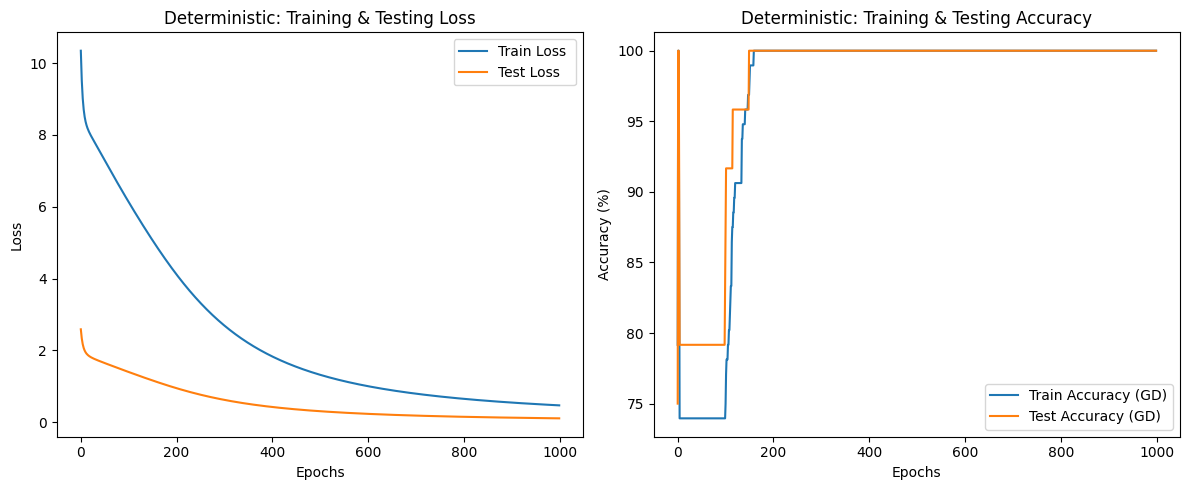


--- OR Dataset ---
                         Deterministic_GD
Final_Testing_Accuracy          83.333333
Final_Testing_Loss               1.360027
Final_Training_Accuracy         91.666667
Final_Training_Loss              4.600359


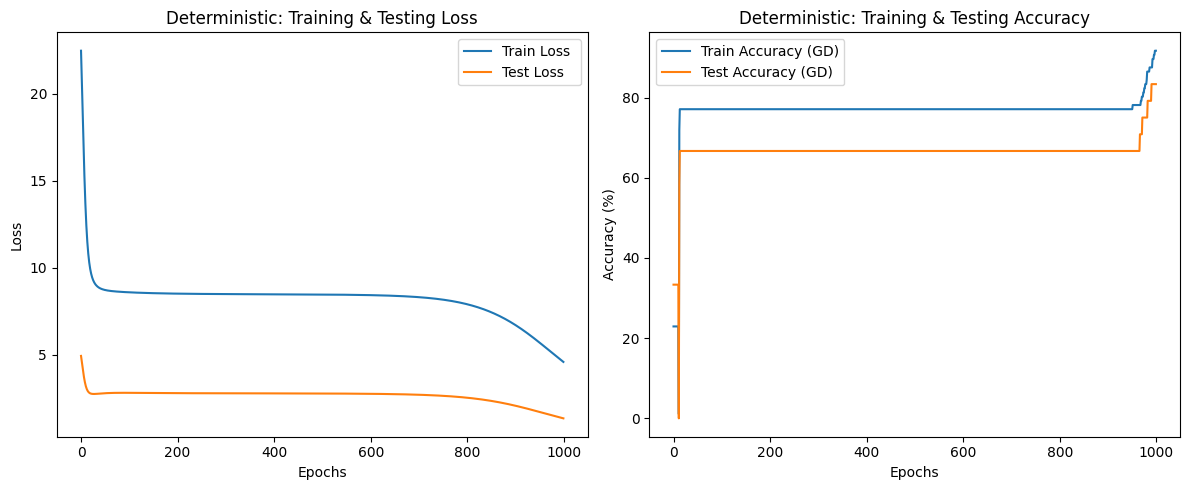


--- Sample Size: 400 ---

--- XOR Dataset ---
                         Deterministic_GD
Final_Testing_Accuracy          75.000000
Final_Testing_Loss               2.012124
Final_Training_Accuracy         75.000000
Final_Training_Loss              8.561436


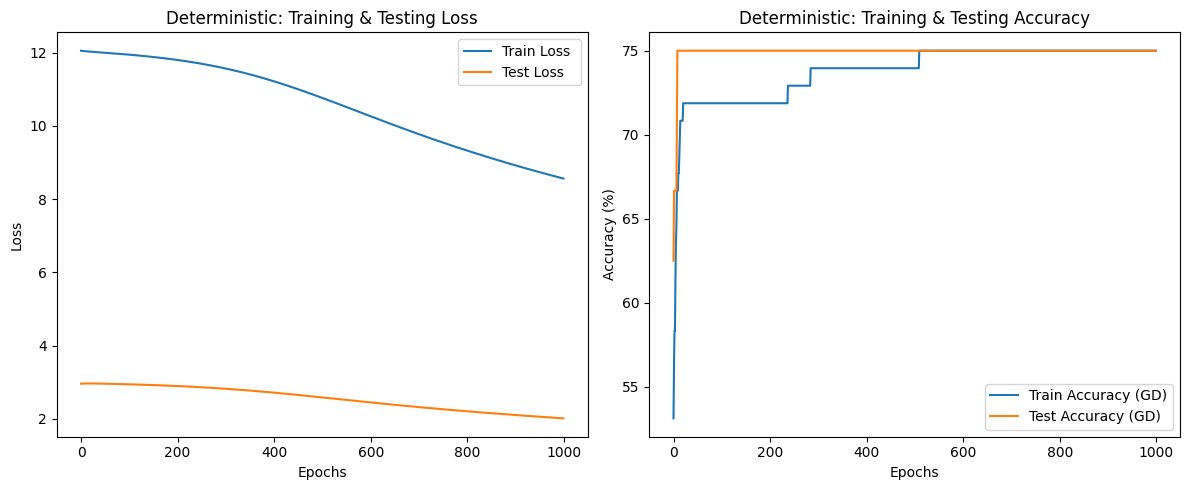


--- AND Dataset ---
                         Deterministic_GD
Final_Testing_Accuracy         100.000000
Final_Testing_Loss               0.084412
Final_Training_Accuracy        100.000000
Final_Training_Loss              0.569898


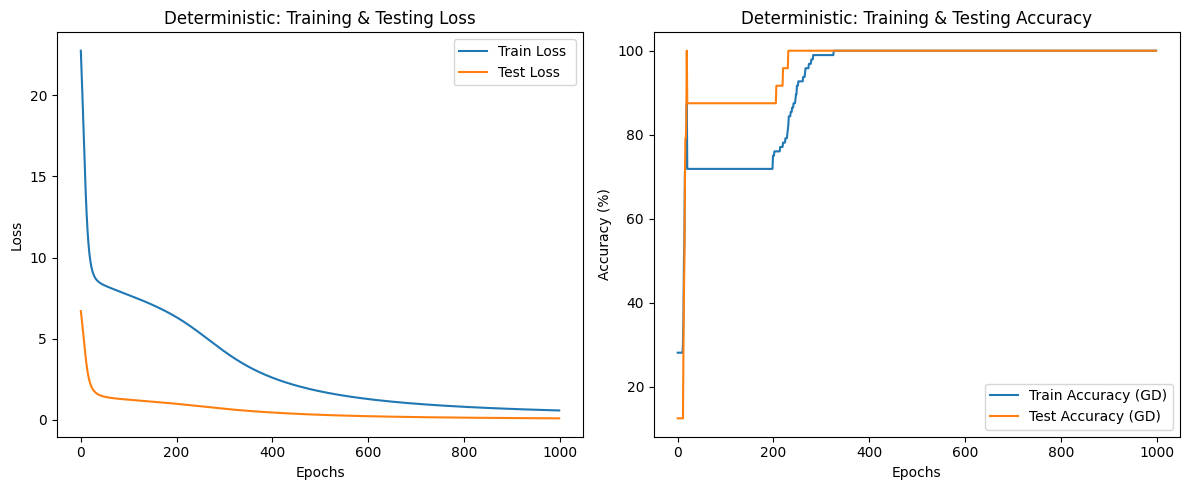


--- OR Dataset ---
                         Deterministic_GD
Final_Testing_Accuracy         100.000000
Final_Testing_Loss               0.160198
Final_Training_Accuracy        100.000000
Final_Training_Loss              0.347653


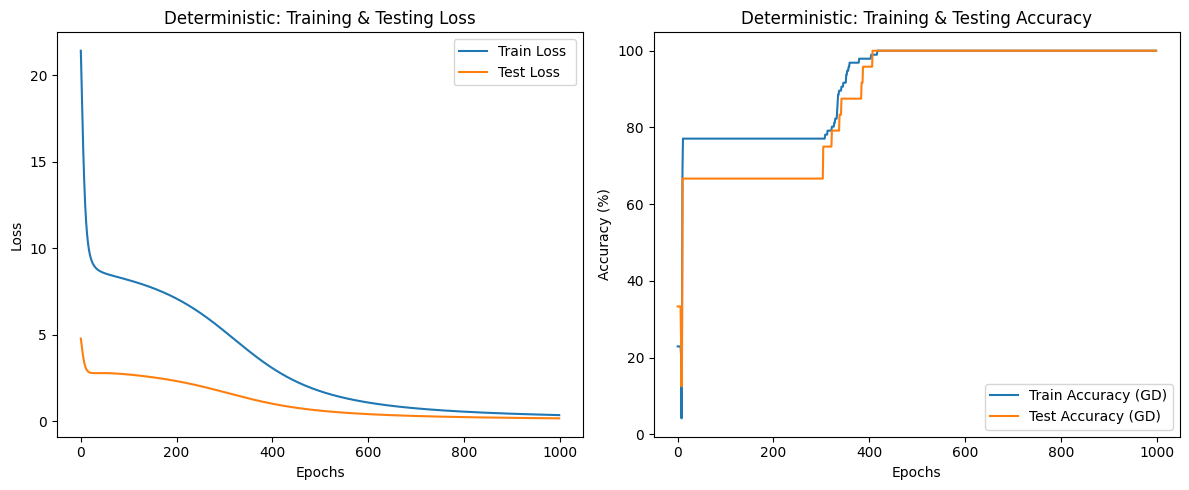


--- Sample Size: 800 ---

--- XOR Dataset ---
                         Deterministic_GD
Final_Testing_Accuracy          66.666667
Final_Testing_Loss               2.630036
Final_Training_Accuracy         77.083333
Final_Training_Loss              9.318071


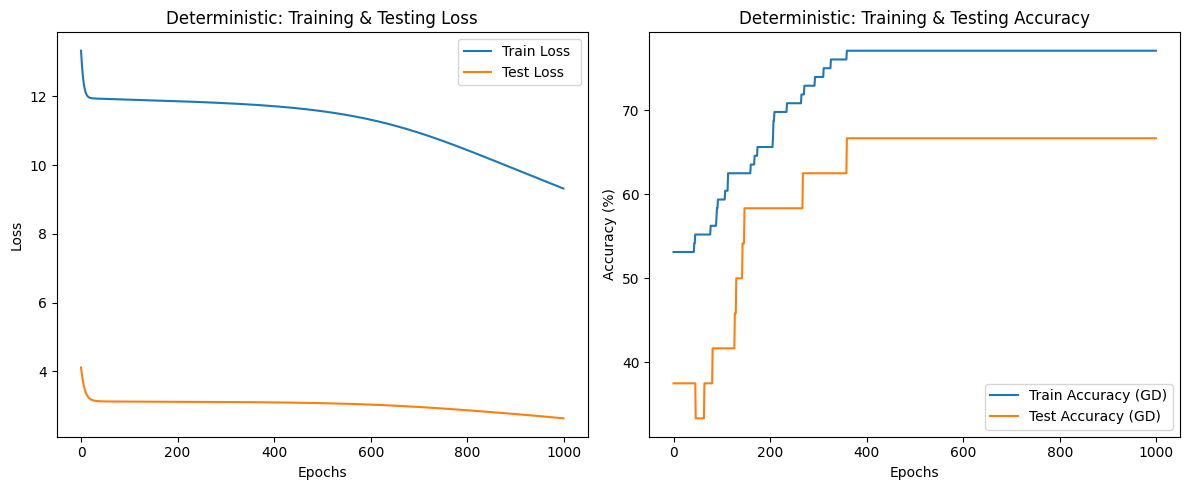


--- AND Dataset ---
                         Deterministic_GD
Final_Testing_Accuracy         100.000000
Final_Testing_Loss               0.144962
Final_Training_Accuracy        100.000000
Final_Training_Loss              0.708327


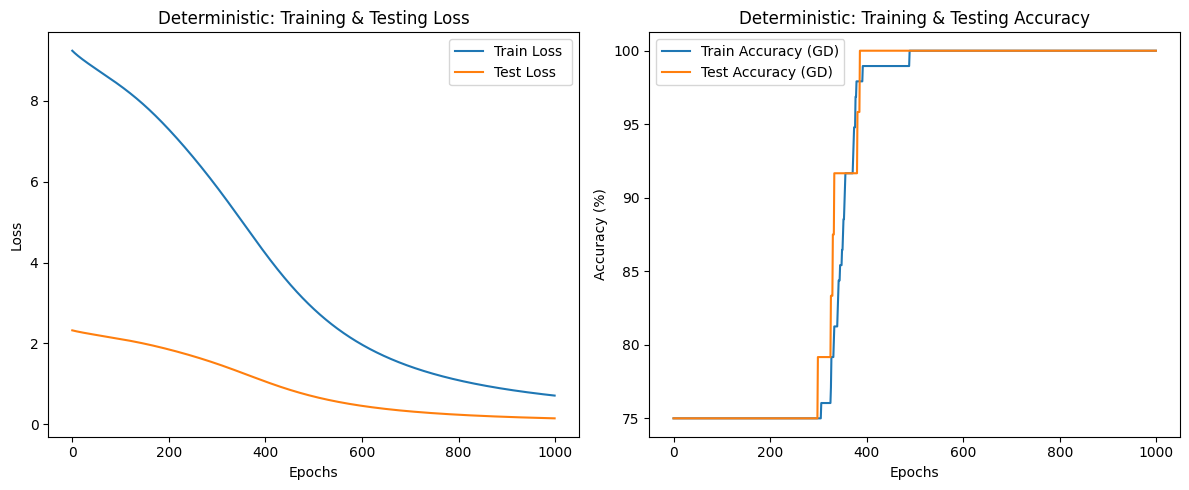


--- OR Dataset ---
                         Deterministic_GD
Final_Testing_Accuracy         100.000000
Final_Testing_Loss               0.091804
Final_Training_Accuracy        100.000000
Final_Training_Loss              0.346631


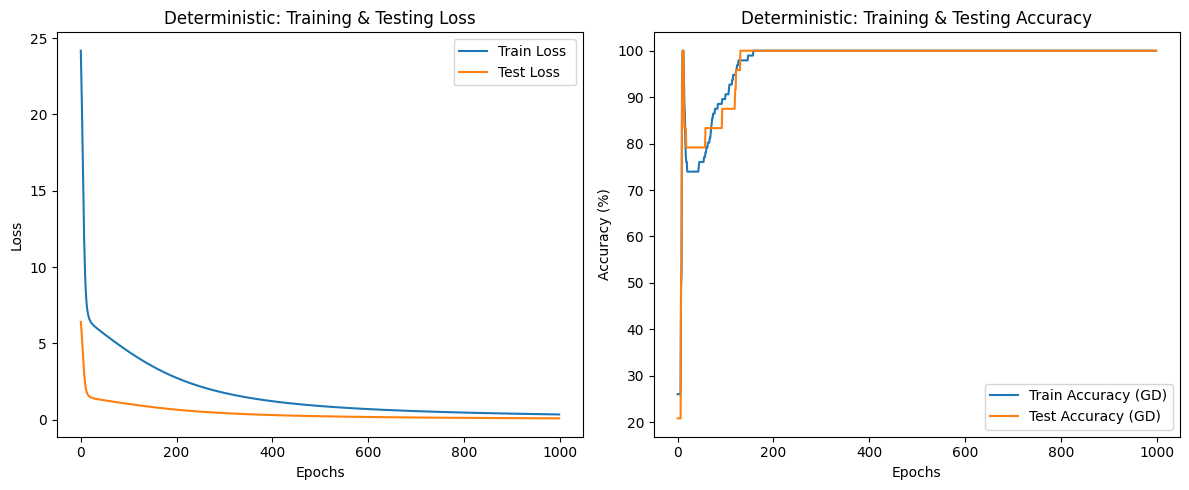

In [140]:
def dataset_prep(n):
  dataset = []
  targets = []
  for key in operations.keys():
    data,labels = generate_data(key,120)
    dataset.append(data)
    targets.append(labels)
  return dataset,targets
n_samples = [200,400,800]
for n in n_samples:
  print(f"\n--- Sample Size: {n} ---")
  dataset,targets = dataset_prep(n)


  xor_dataset,and_dataset,or_dataset = dataset
  xor_targets,and_targets,or_targets = targets
  print(f"\n--- XOR Dataset ---")
  X_train,X_test,y_train,y_test = train_test_split(xor_dataset,xor_targets)
  Deterministic_Model(X_train, y_train, X_test, y_test)
  print(f"\n--- AND Dataset ---")
  X_train,X_test,y_train,y_test = train_test_split(and_dataset,and_targets)
  Deterministic_Model(X_train, y_train, X_test, y_test)
  print(f"\n--- OR Dataset ---")
  X_train,X_test,y_train,y_test = train_test_split(or_dataset,or_targets)
  Deterministic_Model(X_train, y_train, X_test, y_test)



--- Sample Size: 200 ---

--- Batch Size: 10 ---

--- XOR Dataset ---
                               SGD
Final_Testing_Accuracy   70.833333
Final_Testing_Loss        2.210721
Final_Training_Accuracy  70.833333
Final_Training_Loss       8.974552


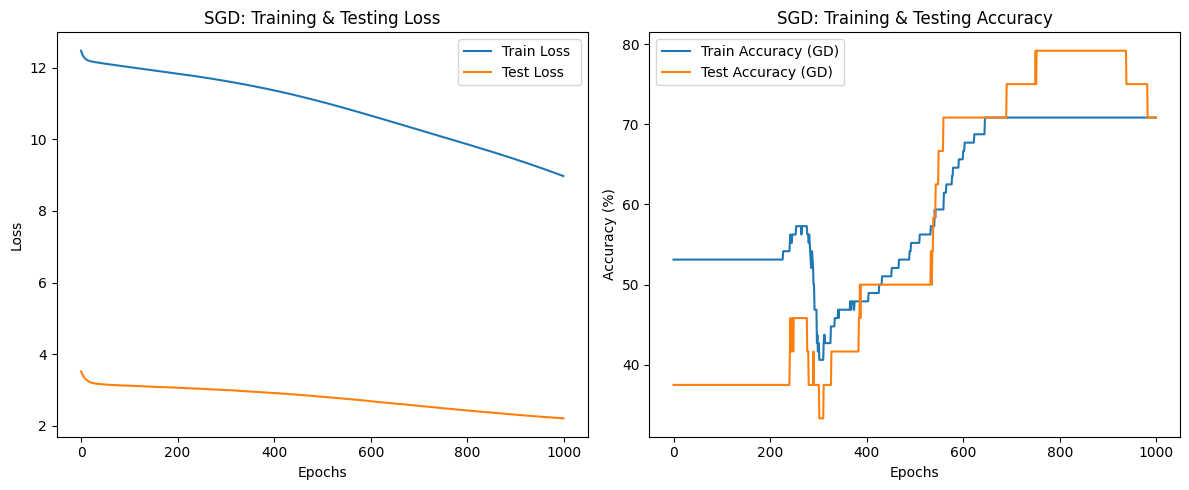


--- AND Dataset ---
                               SGD
Final_Testing_Accuracy   91.666667
Final_Testing_Loss        1.580716
Final_Training_Accuracy  89.583333
Final_Training_Loss       3.942481


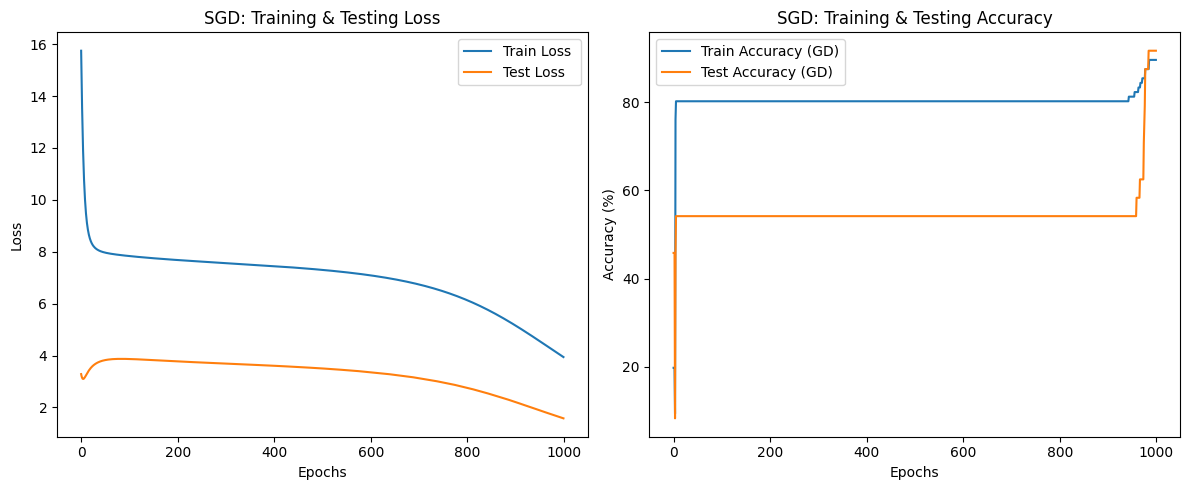


--- OR Dataset ---
                                SGD
Final_Testing_Accuracy   100.000000
Final_Testing_Loss         0.061894
Final_Training_Accuracy  100.000000
Final_Training_Loss        0.264360


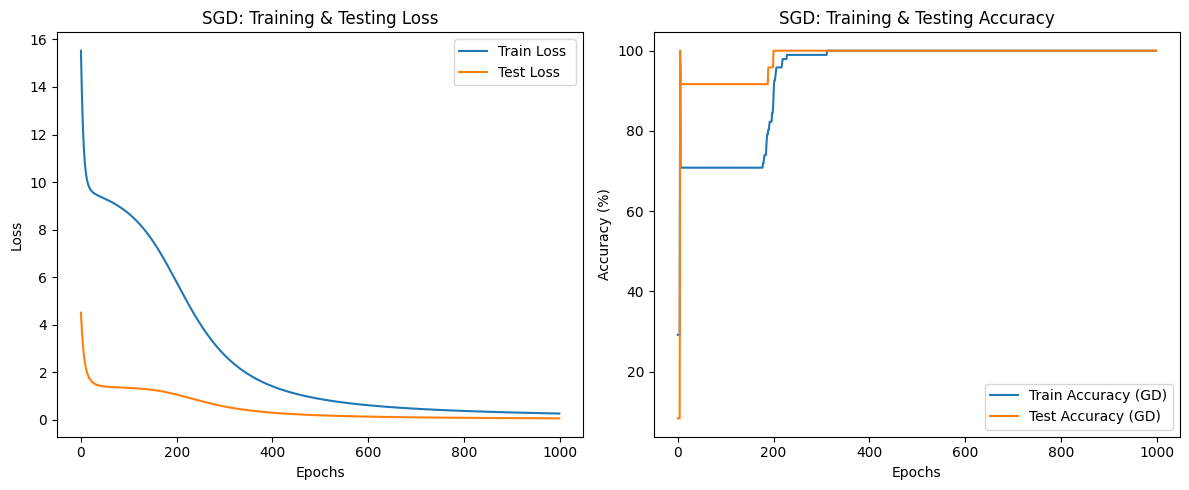


--- Batch Size: 20 ---

--- XOR Dataset ---
                               SGD
Final_Testing_Accuracy   41.666667
Final_Testing_Loss        3.002545
Final_Training_Accuracy  58.333333
Final_Training_Loss      11.789446


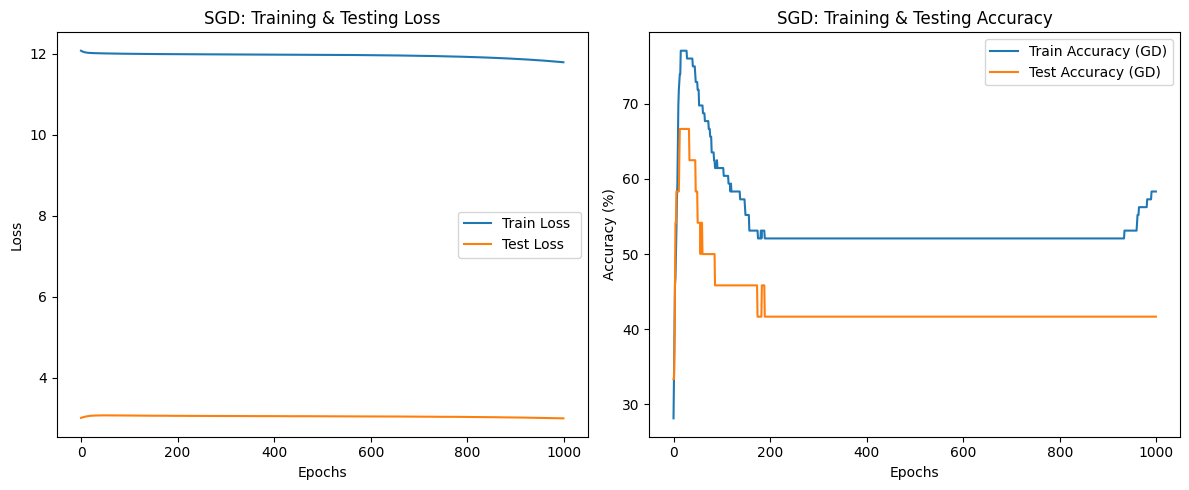


--- AND Dataset ---
                                SGD
Final_Testing_Accuracy   100.000000
Final_Testing_Loss         0.399549
Final_Training_Accuracy  100.000000
Final_Training_Loss        0.939203


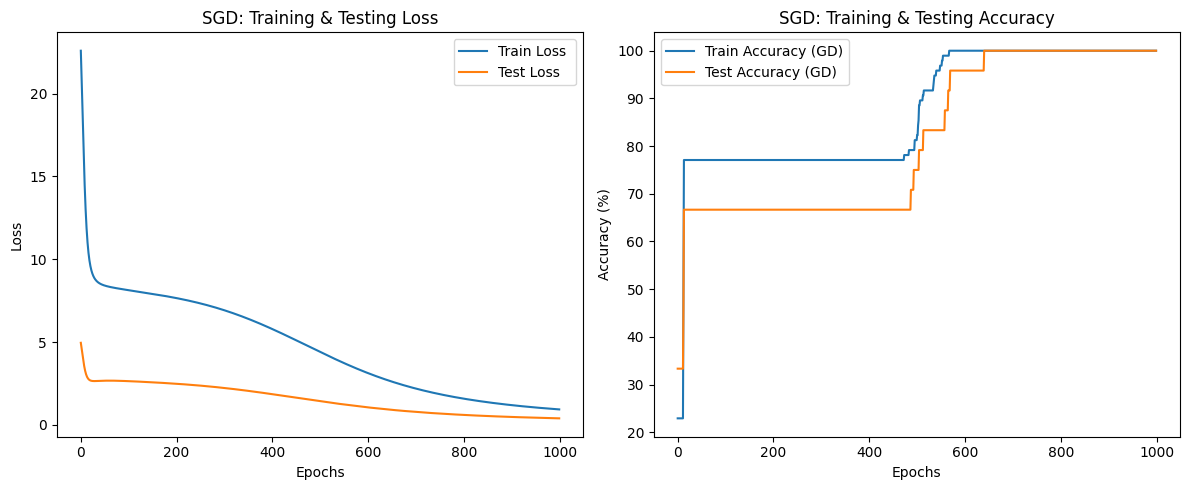


--- OR Dataset ---
                               SGD
Final_Testing_Accuracy   100.00000
Final_Testing_Loss         0.13680
Final_Training_Accuracy  100.00000
Final_Training_Loss        0.26414


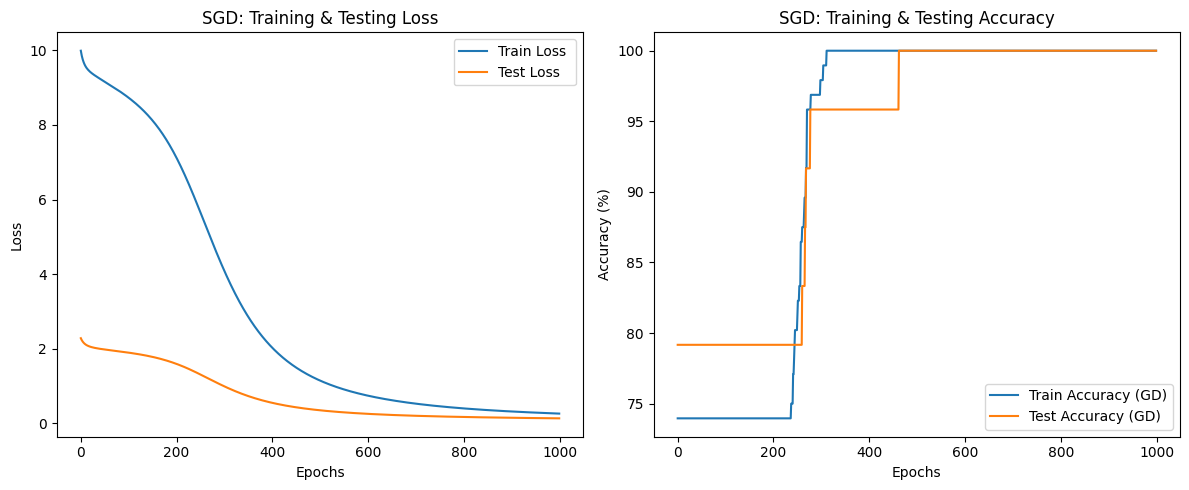


--- Batch Size: 40 ---

--- XOR Dataset ---
                               SGD
Final_Testing_Accuracy   62.500000
Final_Testing_Loss        3.089609
Final_Training_Accuracy  78.125000
Final_Training_Loss      11.942046


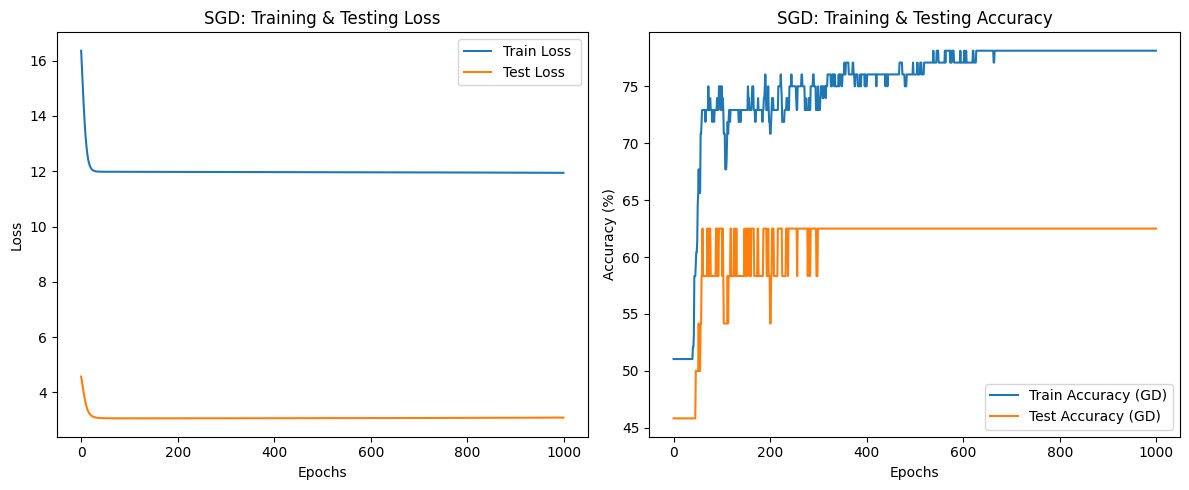


--- AND Dataset ---
                                SGD
Final_Testing_Accuracy   100.000000
Final_Testing_Loss         0.365764
Final_Training_Accuracy  100.000000
Final_Training_Loss        1.160464


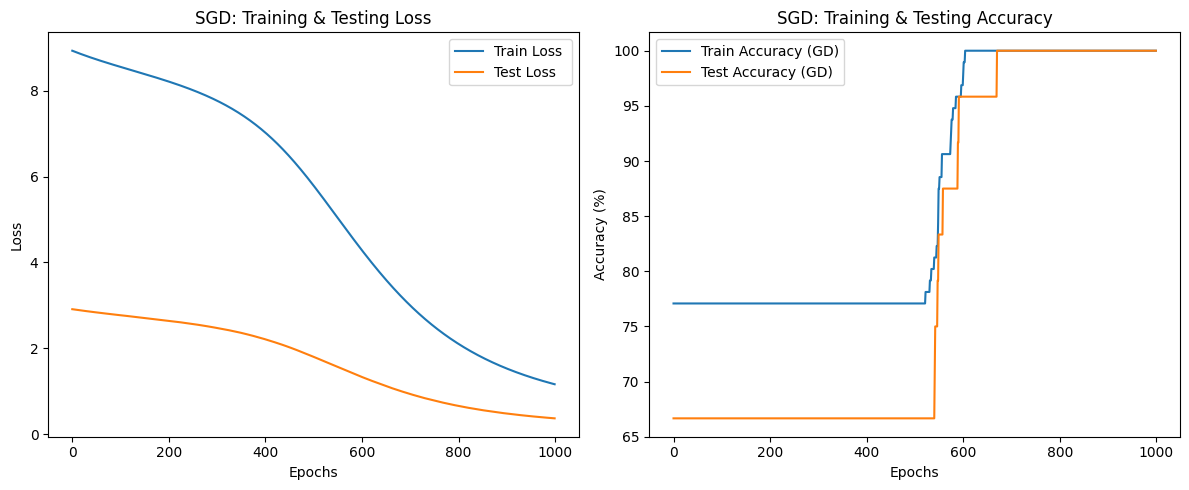


--- OR Dataset ---
                                SGD
Final_Testing_Accuracy   100.000000
Final_Testing_Loss         0.128168
Final_Training_Accuracy  100.000000
Final_Training_Loss        0.236943


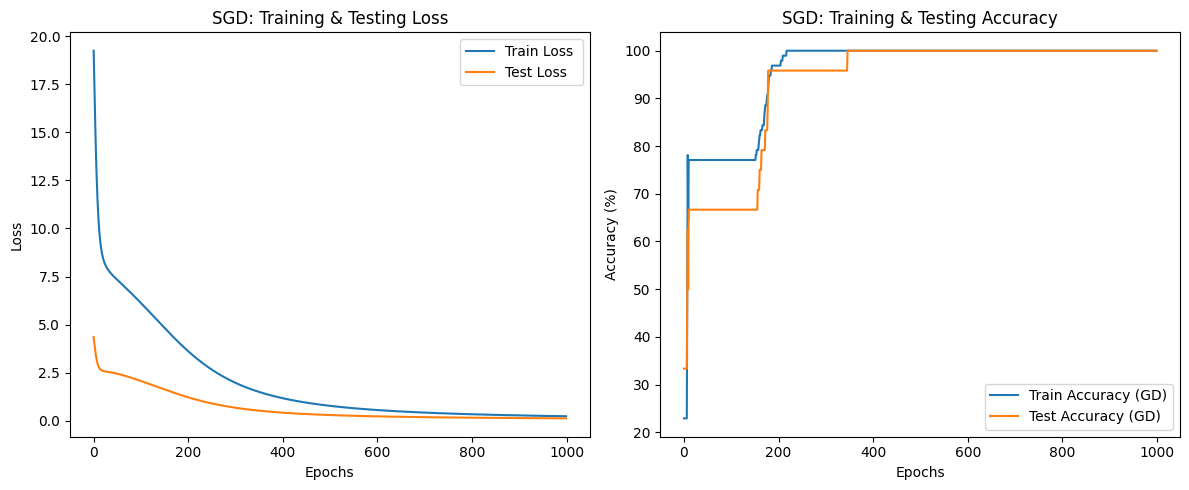


--- Sample Size: 400 ---

--- Batch Size: 10 ---

--- XOR Dataset ---
                               SGD
Final_Testing_Accuracy   75.000000
Final_Testing_Loss        2.978269
Final_Training_Accuracy  73.958333
Final_Training_Loss      11.875929


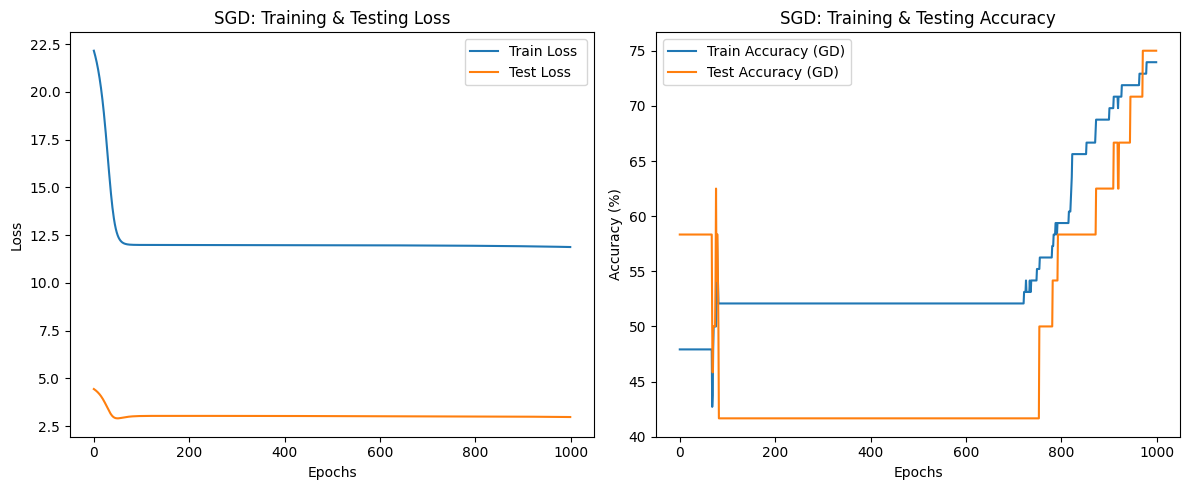


--- AND Dataset ---
                                SGD
Final_Testing_Accuracy   100.000000
Final_Testing_Loss         0.150843
Final_Training_Accuracy  100.000000
Final_Training_Loss        0.555110


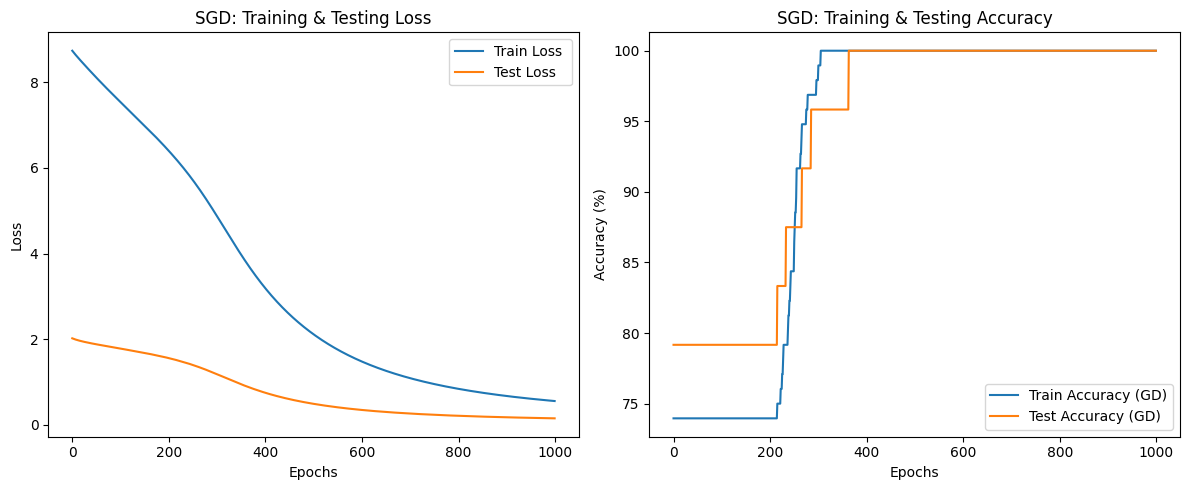


--- OR Dataset ---
                                SGD
Final_Testing_Accuracy   100.000000
Final_Testing_Loss         0.237722
Final_Training_Accuracy  100.000000
Final_Training_Loss        0.593228


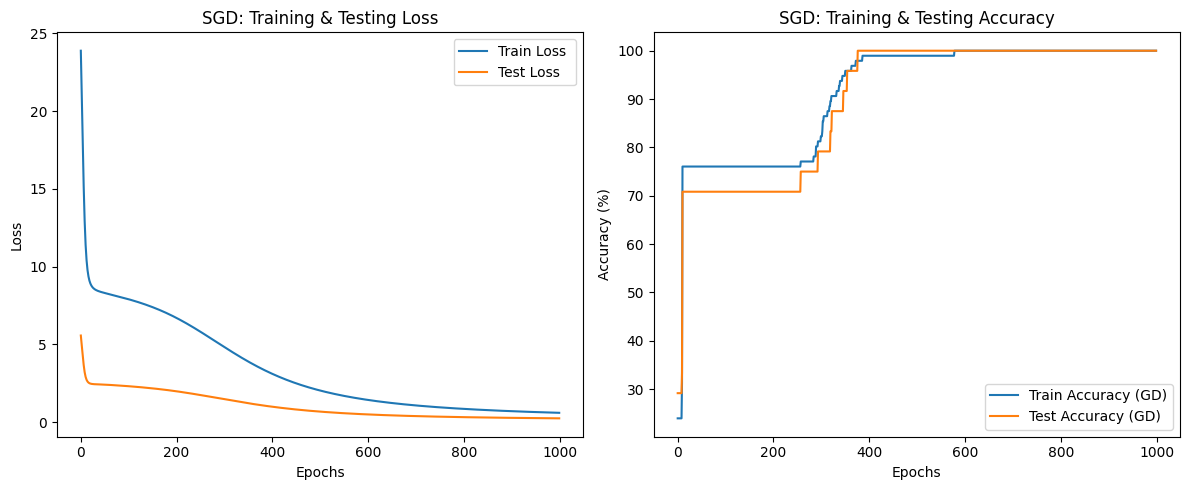


--- Batch Size: 20 ---

--- XOR Dataset ---
                               SGD
Final_Testing_Accuracy   79.166667
Final_Testing_Loss        2.750732
Final_Training_Accuracy  73.958333
Final_Training_Loss      11.123311


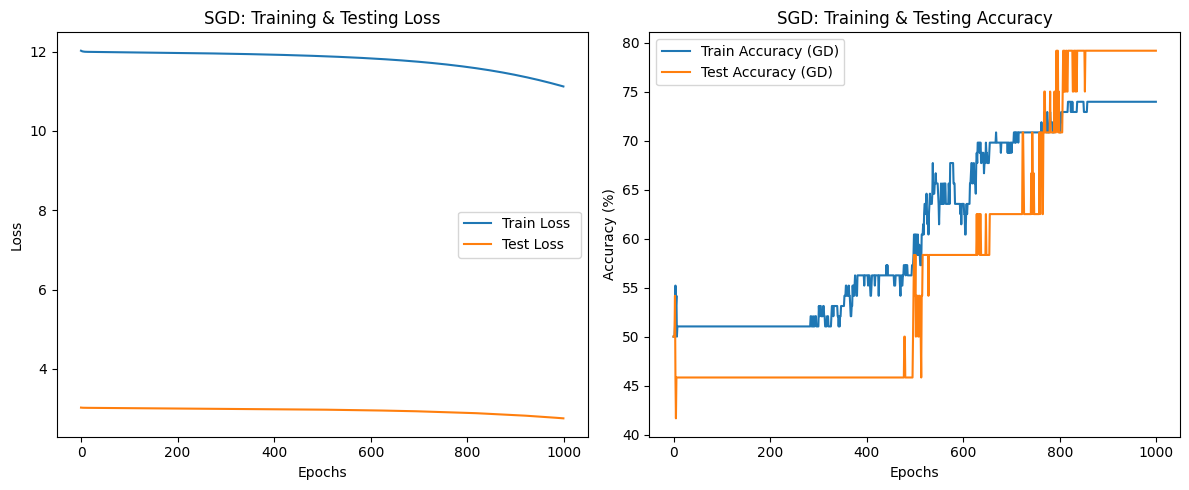


--- AND Dataset ---
                                SGD
Final_Testing_Accuracy   100.000000
Final_Testing_Loss         0.138580
Final_Training_Accuracy  100.000000
Final_Training_Loss        0.558286


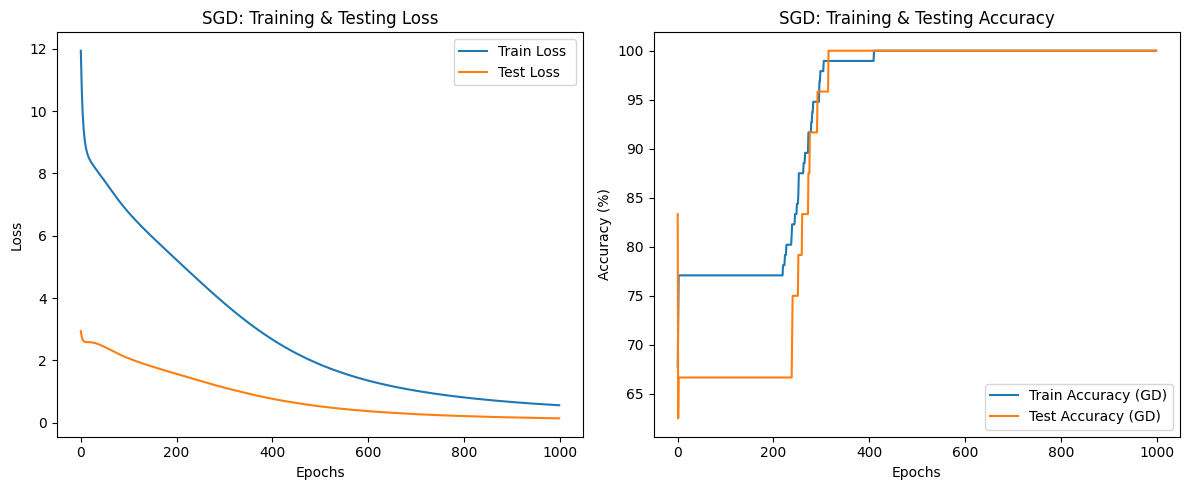


--- OR Dataset ---
                                SGD
Final_Testing_Accuracy   100.000000
Final_Testing_Loss         0.235301
Final_Training_Accuracy  100.000000
Final_Training_Loss        0.629180


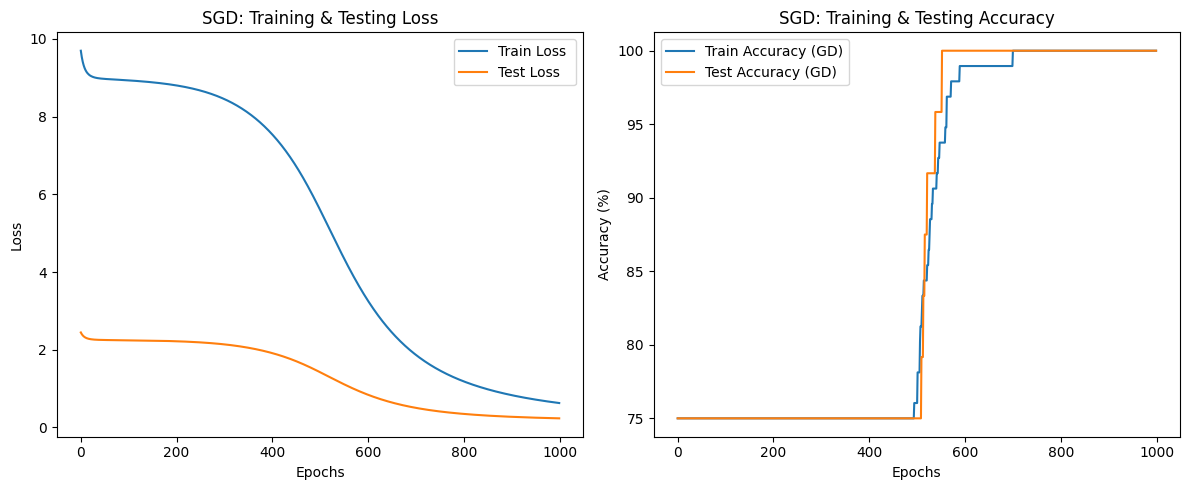


--- Batch Size: 40 ---

--- XOR Dataset ---
                               SGD
Final_Testing_Accuracy   75.000000
Final_Testing_Loss        2.659876
Final_Training_Accuracy  75.000000
Final_Training_Loss      10.221926


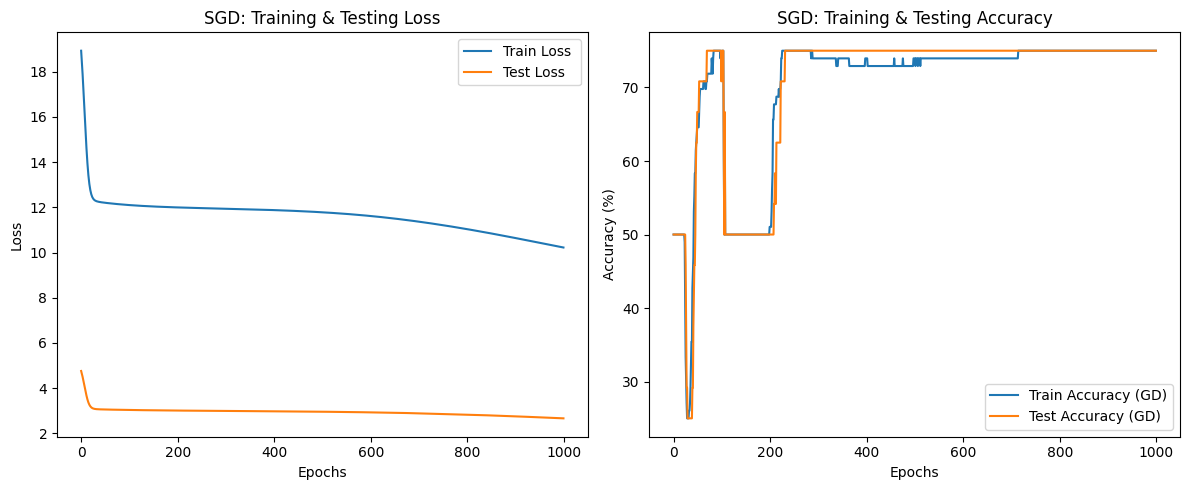


--- AND Dataset ---
                                SGD
Final_Testing_Accuracy   100.000000
Final_Testing_Loss         0.219304
Final_Training_Accuracy  100.000000
Final_Training_Loss        0.812478


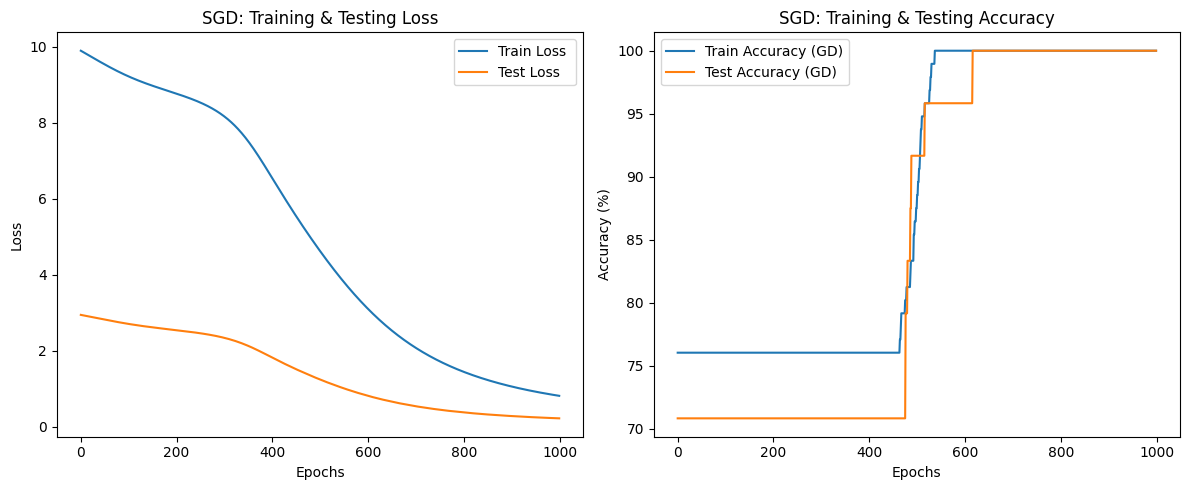


--- OR Dataset ---
                                SGD
Final_Testing_Accuracy   100.000000
Final_Testing_Loss         0.104061
Final_Training_Accuracy  100.000000
Final_Training_Loss        0.467884


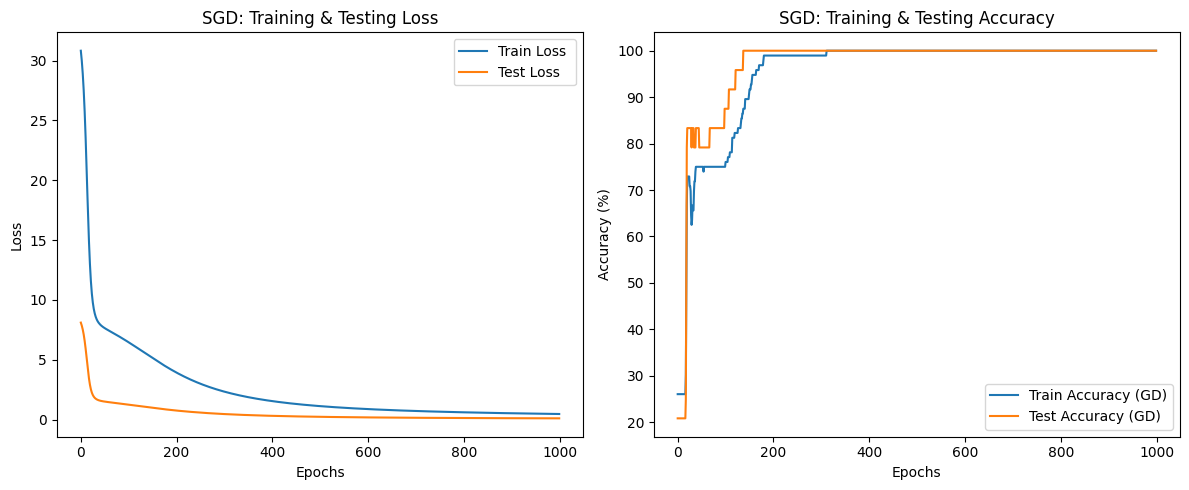


--- Sample Size: 800 ---

--- Batch Size: 10 ---

--- XOR Dataset ---
                               SGD
Final_Testing_Accuracy   54.166667
Final_Testing_Loss        3.476006
Final_Training_Accuracy  80.208333
Final_Training_Loss       8.300276


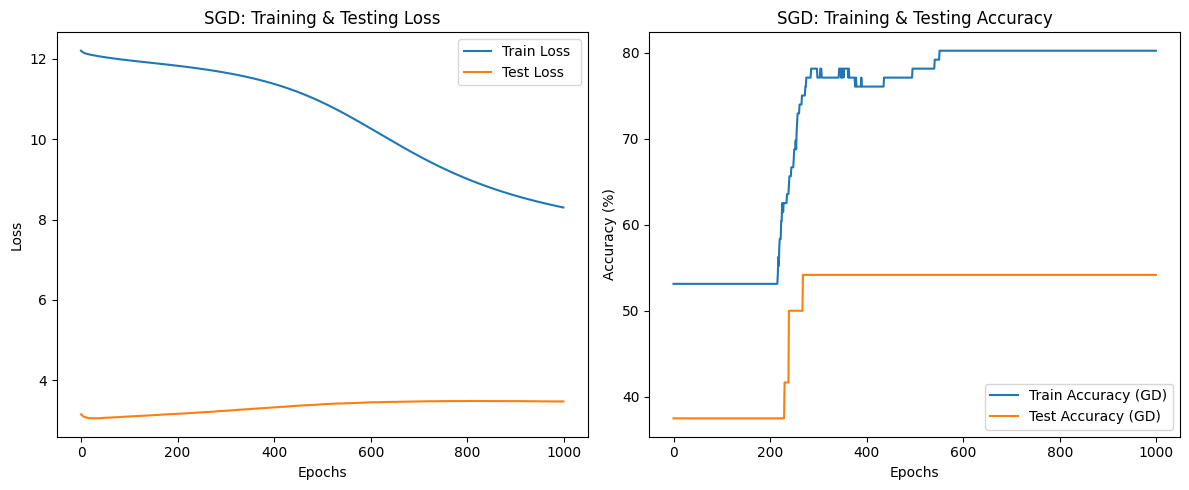


--- AND Dataset ---
                                SGD
Final_Testing_Accuracy   100.000000
Final_Testing_Loss         0.128206
Final_Training_Accuracy  100.000000
Final_Training_Loss        0.399479


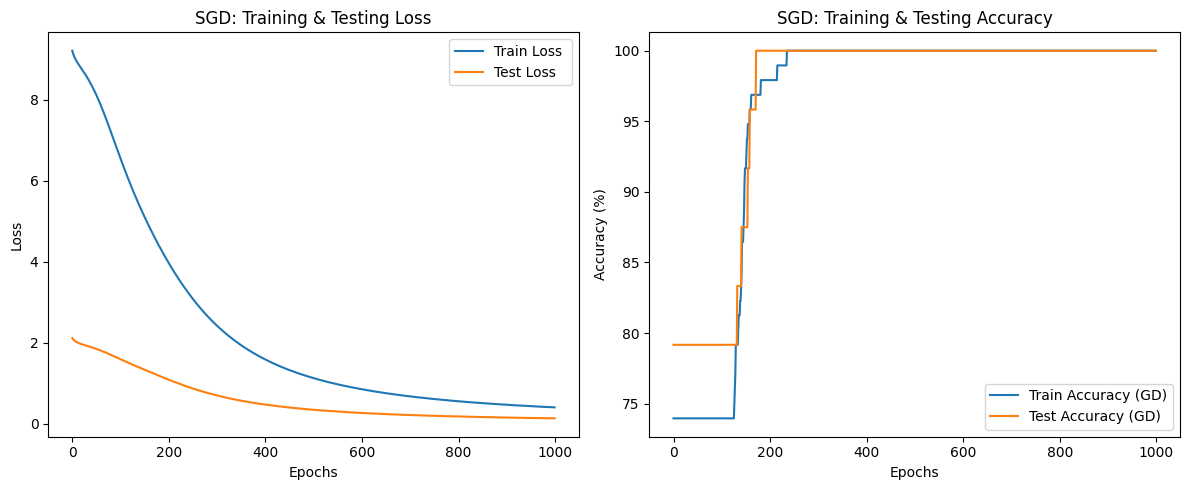


--- OR Dataset ---
                                SGD
Final_Testing_Accuracy   100.000000
Final_Testing_Loss         0.215307
Final_Training_Accuracy  100.000000
Final_Training_Loss        0.759974


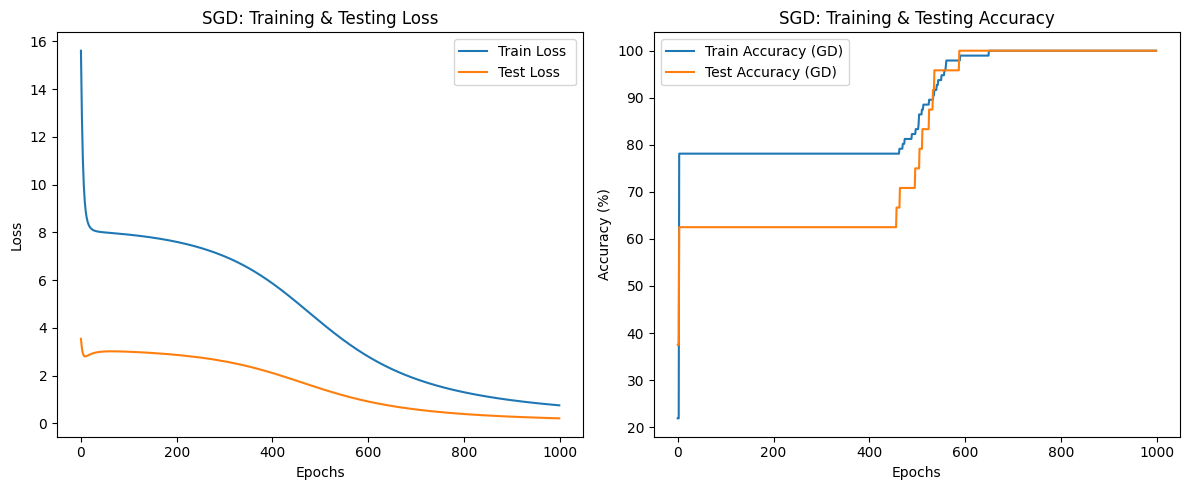


--- Batch Size: 20 ---

--- XOR Dataset ---
                               SGD
Final_Testing_Accuracy   50.000000
Final_Testing_Loss        2.871391
Final_Training_Accuracy  80.208333
Final_Training_Loss       8.415779


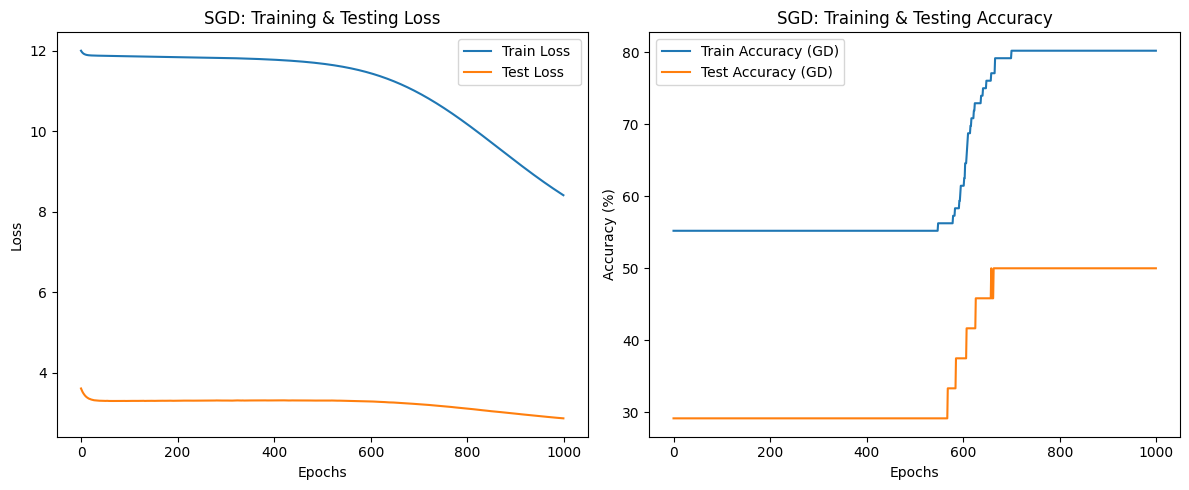


--- AND Dataset ---
                                SGD
Final_Testing_Accuracy   100.000000
Final_Testing_Loss         0.094303
Final_Training_Accuracy  100.000000
Final_Training_Loss        0.516114


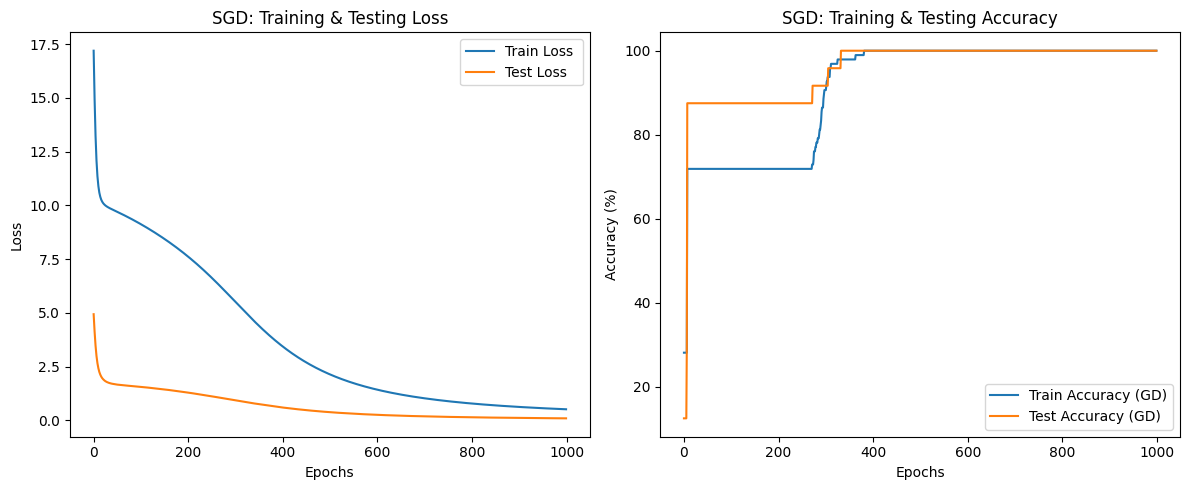


--- OR Dataset ---
                                SGD
Final_Testing_Accuracy   100.000000
Final_Testing_Loss         0.043465
Final_Training_Accuracy  100.000000
Final_Training_Loss        0.371534


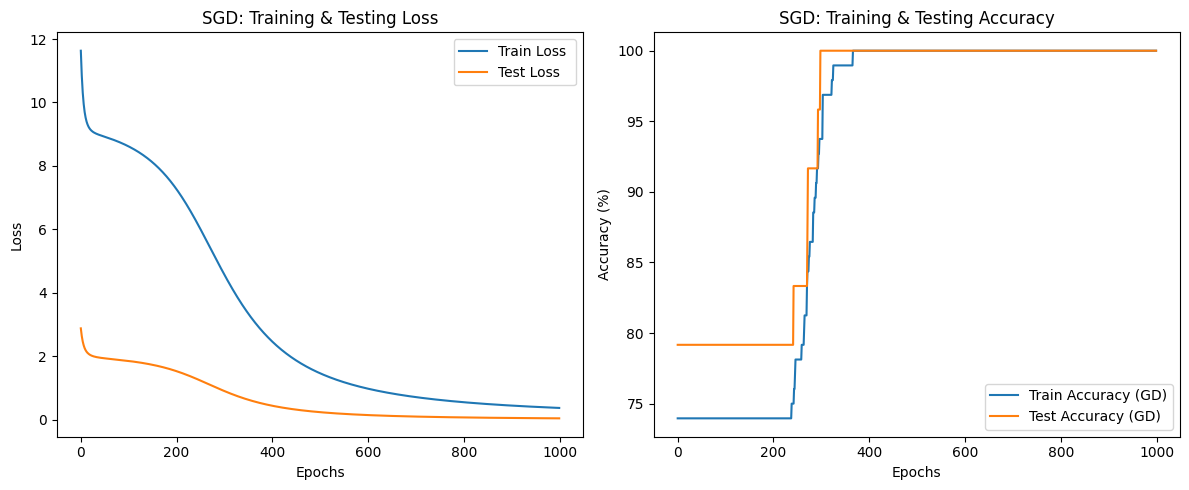


--- Batch Size: 40 ---

--- XOR Dataset ---
                               SGD
Final_Testing_Accuracy   70.833333
Final_Testing_Loss        2.508209
Final_Training_Accuracy  76.041667
Final_Training_Loss       9.615496


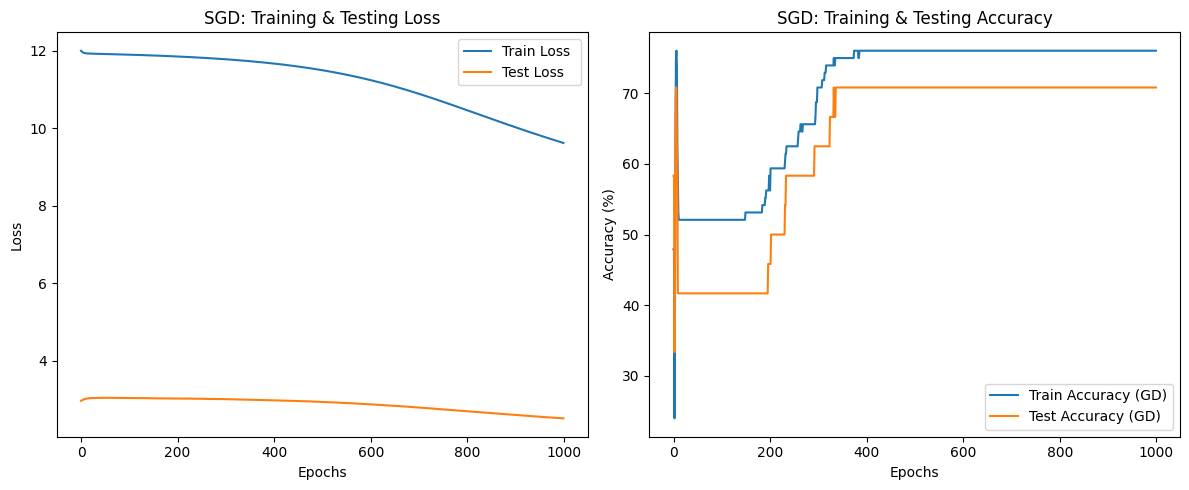


--- AND Dataset ---
                                SGD
Final_Testing_Accuracy   100.000000
Final_Testing_Loss         0.195116
Final_Training_Accuracy  100.000000
Final_Training_Loss        0.505770


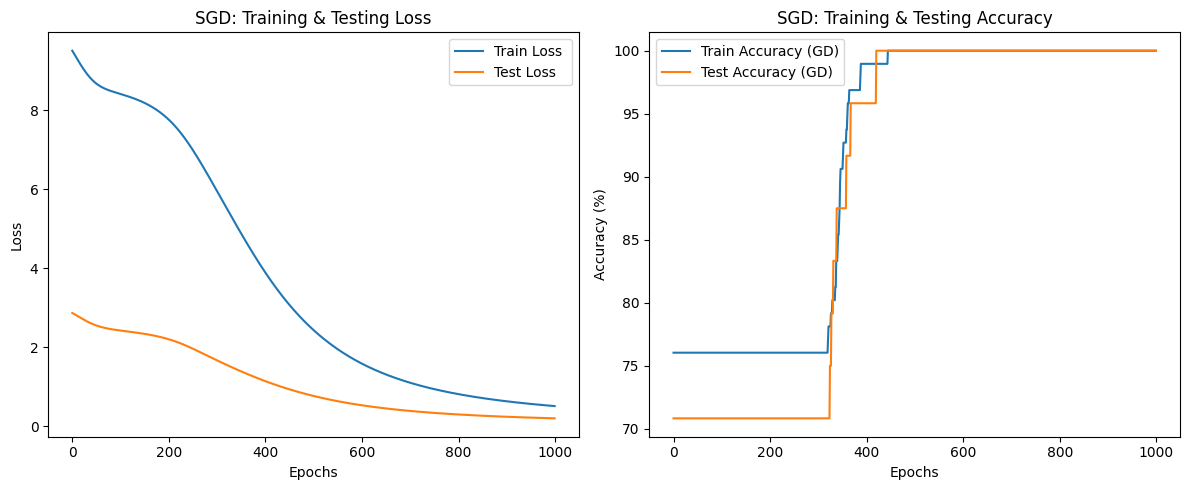


--- OR Dataset ---
                                SGD
Final_Testing_Accuracy   100.000000
Final_Testing_Loss         0.144938
Final_Training_Accuracy  100.000000
Final_Training_Loss        0.682073


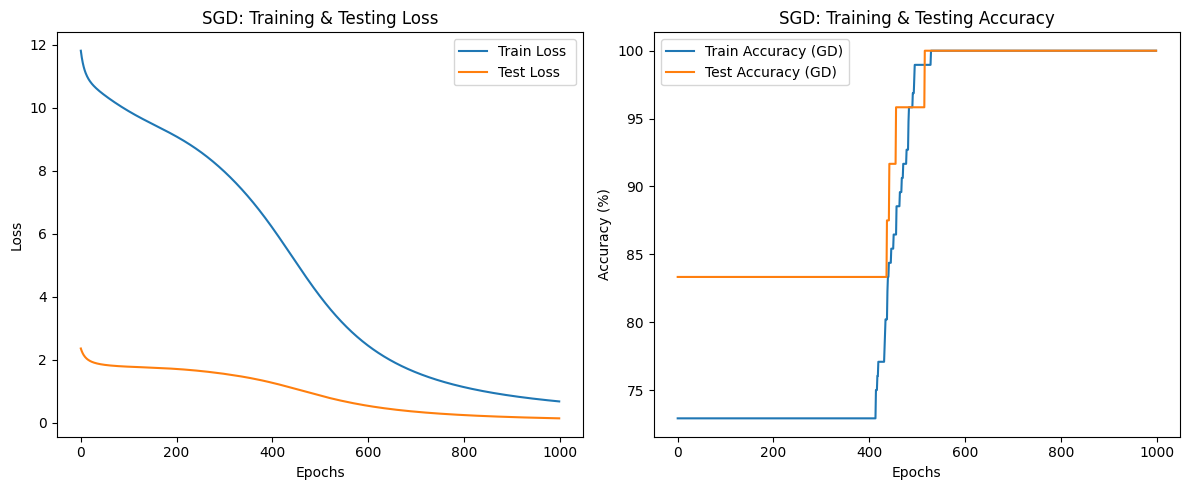

In [141]:
n_samples = [200,400,800]
batch_size = [10,20,40]
for n in n_samples:
  print(f"\n--- Sample Size: {n} ---")
  dataset,targets = dataset_prep(n)


  xor_dataset,and_dataset,or_dataset = dataset
  xor_targets,and_targets,or_targets = targets
  for size in batch_size:
    print(f"\n--- Batch Size: {size} ---")
    print(f"\n--- XOR Dataset ---")
    X_train,X_test,y_train,y_test = train_test_split(xor_dataset,xor_targets)
    SGD_Model(X_train, y_train, X_test, y_test,size)
    print(f"\n--- AND Dataset ---")
    X_train,X_test,y_train,y_test = train_test_split(and_dataset,and_targets)
    SGD_Model(X_train, y_train, X_test, y_test,size)
    print(f"\n--- OR Dataset ---")
    X_train,X_test,y_train,y_test = train_test_split(or_dataset,or_targets)
    SGD_Model(X_train, y_train, X_test, y_test,size)